In [1]:
# imports
%load_ext autoreload
%autoreload 2
import time
from timeit import default_timer as timer
from victor_thesis_experiments_testing import *
from victor_thesis_utils import *
from victor_thesis_landscapes import *
from victor_thesis_plots import *
from victor_thesis_metrics import *
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

starting
done


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


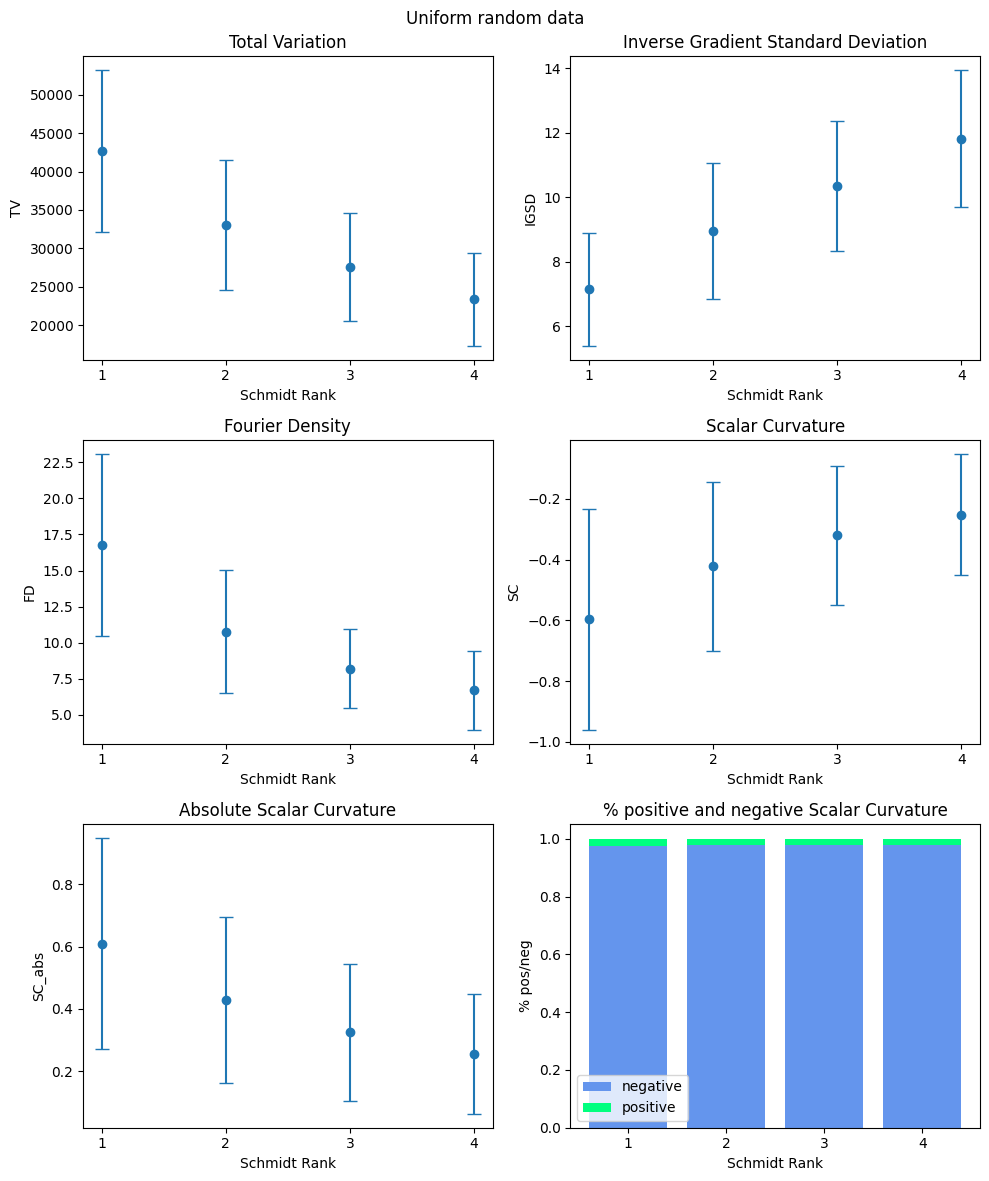

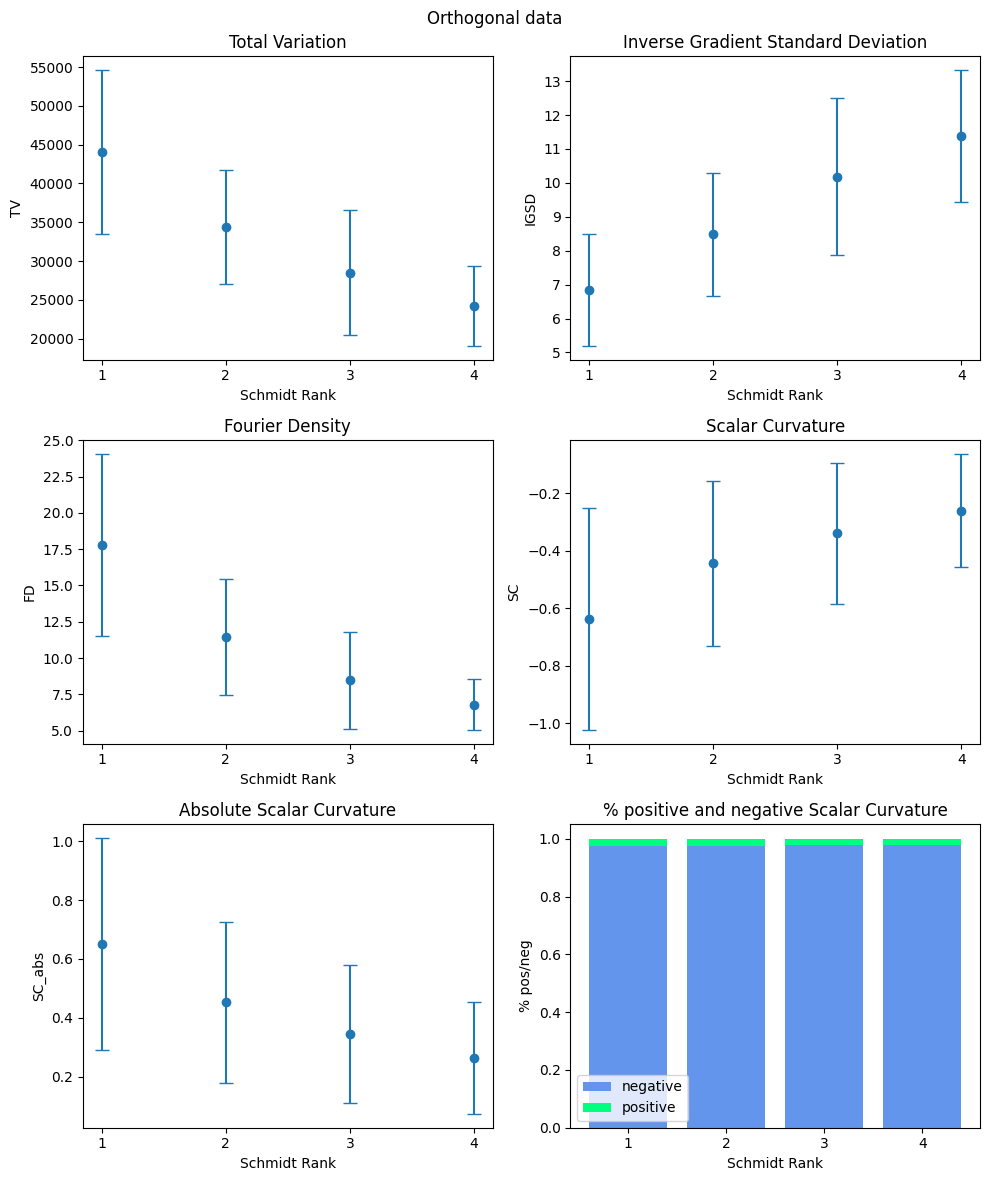

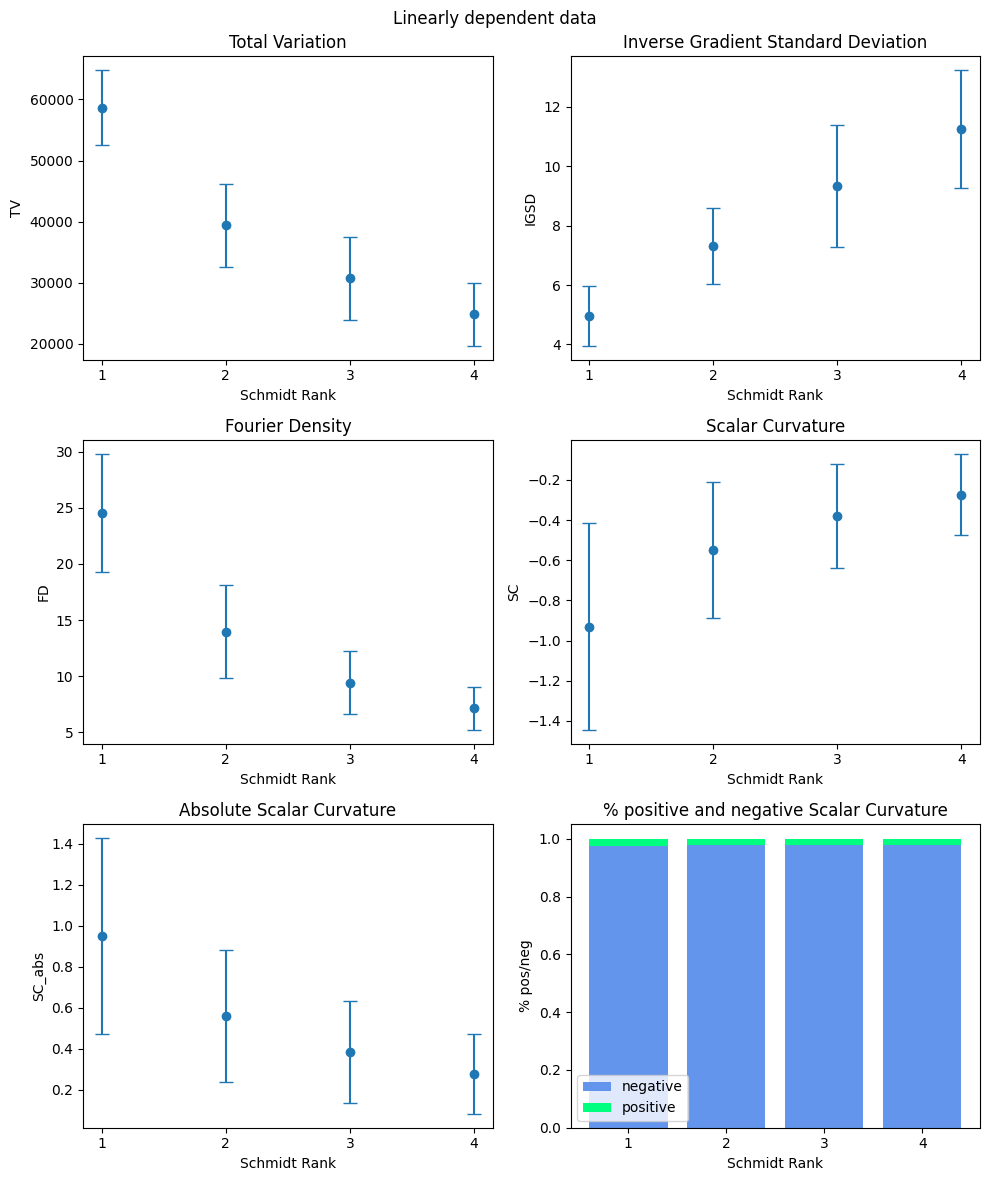

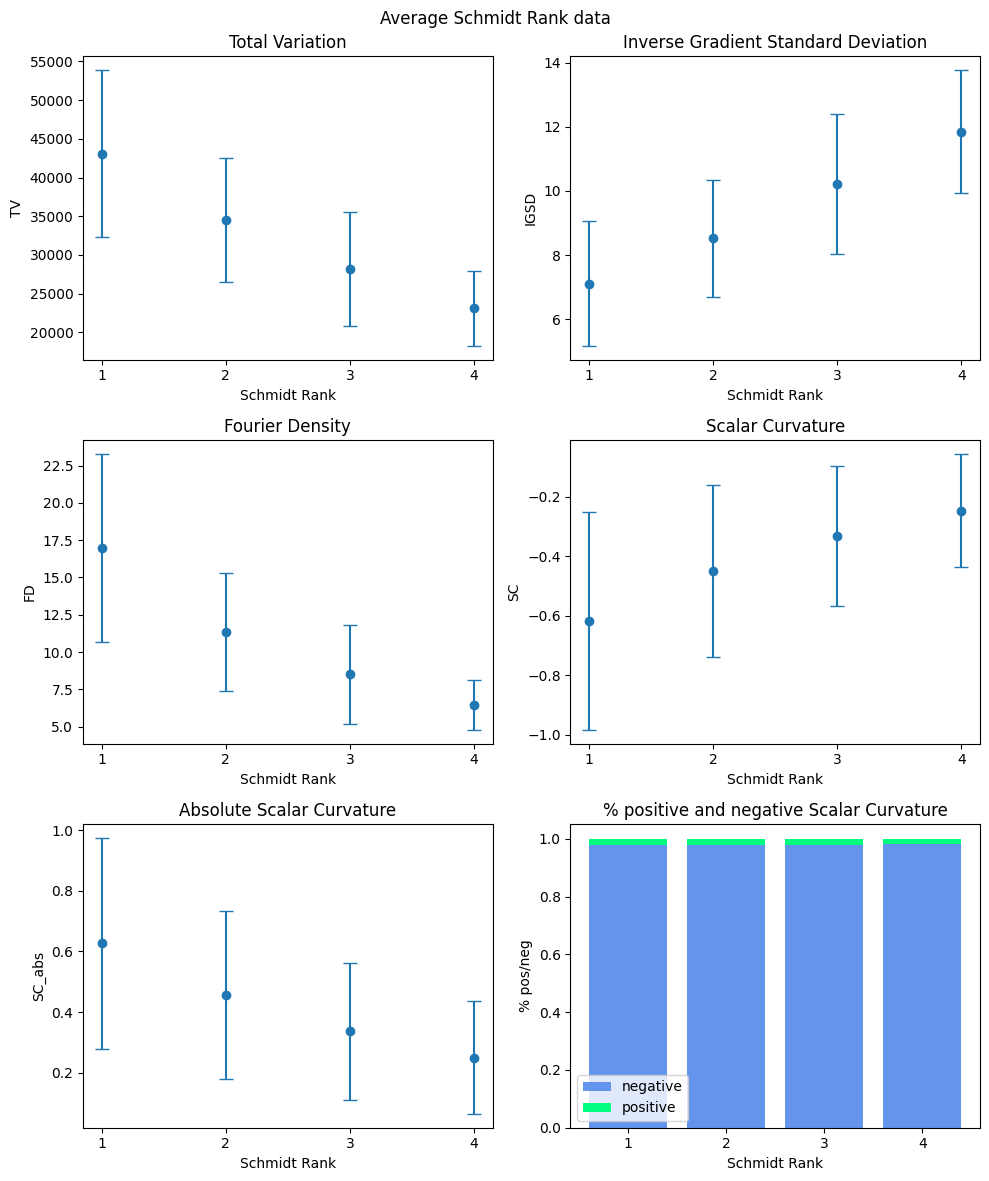

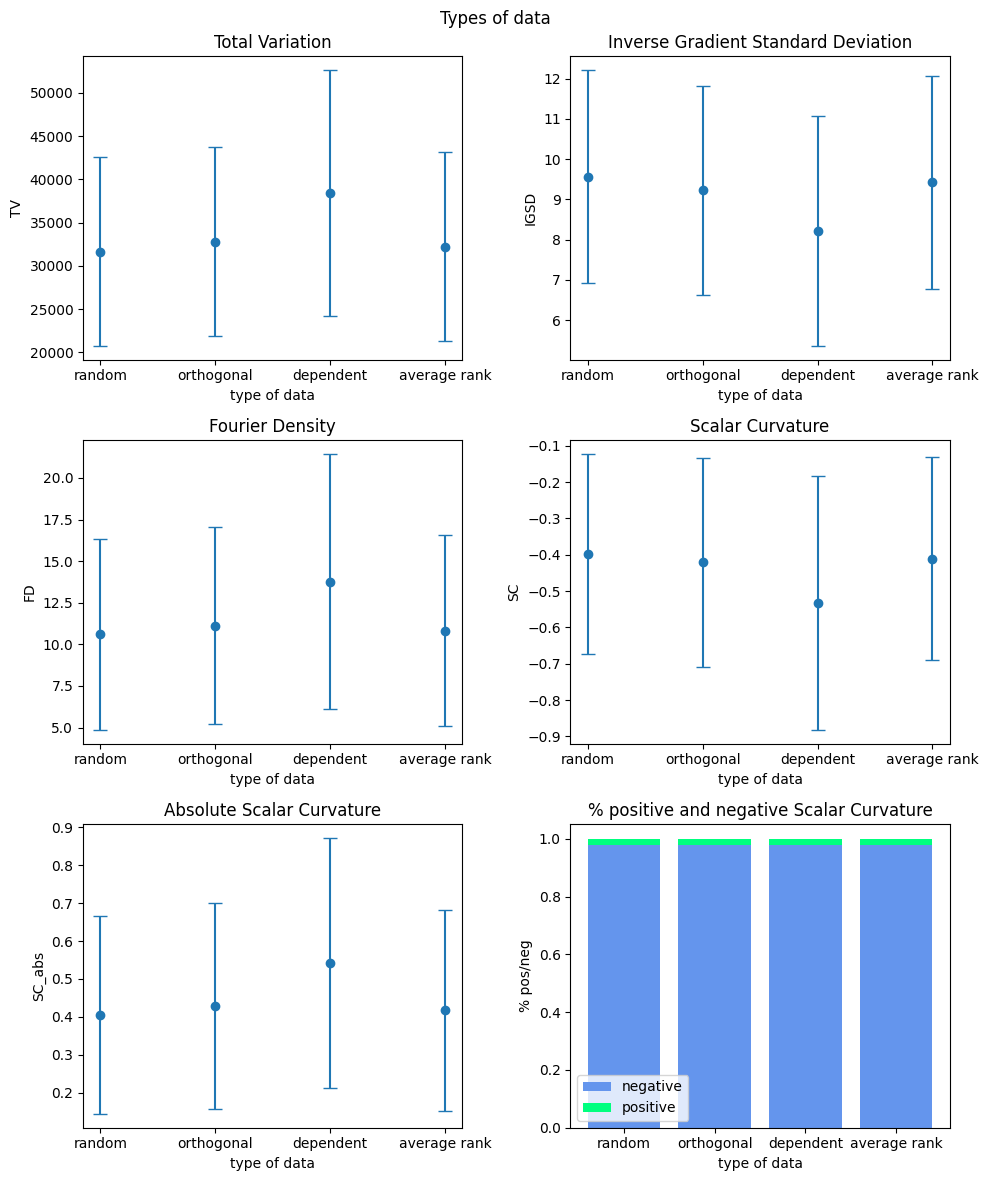

In [3]:
# EXPERIMENT RESULTS HERE
%load_ext autoreload
%autoreload 2
from victor_thesis_results_processing import *
run_id = "3_6_4_4_12_27_58"
datatype_labels = ["random", "orthogonal","dependent","average rank"]
results, configs = get_results(run_id)
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1, schmidt_rank=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1, schmidt_rank=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1, schmidt_rank=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1, schmidt_rank=4)))
visualize_metrics(combined_results_list, "Schmidt Rank", "Uniform random data")
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2, schmidt_rank=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2, schmidt_rank=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2, schmidt_rank=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2, schmidt_rank=4)))
visualize_metrics(combined_results_list, "Schmidt Rank", "Orthogonal data")
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, schmidt_rank=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, schmidt_rank=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, schmidt_rank=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, schmidt_rank=4)))
visualize_metrics(combined_results_list, "Schmidt Rank", "Linearly dependent data")
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4, schmidt_rank=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4, schmidt_rank=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4, schmidt_rank=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4, schmidt_rank=4)))
visualize_metrics(combined_results_list, "Schmidt Rank", "Average Schmidt Rank data")
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4)))
visualize_metrics(combined_results_list, "type of data", "Types of data", sample_labels=datatype_labels)



In [1]:
# test memory usage of landscape and sc generation
import gc
from qnns.cuda_qnn import CudaPennylane
from victor_thesis_experiments_main import process_sc_metrics
from memory_profiler import memory_usage
from time import sleep
def efficient_calc_scalar_curvature(landscape):
    """calculates the scalar curvature of a loss landscape
    instead of calculating the whole n dimensional curvature array (same size as the input landscape)
    this function calculates the scalar curvature at each entry of the n dimensional landscape 
    and puts them back together into an output array

    Args:
        landscape (array): n dimensional loss landscape array

    Returns:
        array: n dimensional scalar curvature array
    """
    landscape = np.asarray(landscape)
    scalar_curvature = np.ndarray(landscape.shape)
    print(scalar_curvature.shape)
    dims = len(landscape.shape)
    first_order_gradients = np.asarray(np.gradient(np.asarray(landscape)))
    second_order_gradients = []
    for grad in first_order_gradients:
        # should go like e.g. xx, xy, xz, yx, yy, yz, zx, zy, zz for 3d
        temp = np.asarray(np.gradient(np.array(grad)))
        for arr in temp:
            second_order_gradients.append(arr)
    second_order_gradients = np.asarray(second_order_gradients)
    # iterate over all landscape entries where idx is the exact position in the array (i.e: idx = (11, 2, 9, 10) -> arr[11][2][9][10] for a 4param qnn)
    for idx, _ in np.ndenumerate(landscape):
        # generate dimsXdims hessian and dims sized vector of gradients for a specific point of the loss landscape
        point_hessian = []
        gradient_vector = []
        for i in range(dims):
            gradient_vector.append(first_order_gradients[i][idx])
            row = []
            for j in range(dims):
                # append e.g. [[0],[1]],[[2],[3]] for 2d
                row.append(second_order_gradients[i * dims + j][idx])
            point_hessian.append(row)
        point_hessian = np.asarray(point_hessian)
        gradient_vector = np.asarray(gradient_vector)
        # calculate scalar curvature from here
        beta = 1 / (1 + np.linalg.norm(gradient_vector) ** 2)
        left_term = beta * (
            np.trace(point_hessian) ** 2
            - np.trace(np.matmul(point_hessian, point_hessian))
        )
        right_inner = np.matmul(point_hessian, point_hessian) - np.trace(
            point_hessian
        ) * np.asarray(point_hessian)
        # order of matmul with gradient does not matter
        right_term = (
            2
            * (beta**2)
            * (np.matmul(np.matmul(gradient_vector.T, right_inner), gradient_vector))
        )
        point_curv = left_term + right_term
        scalar_curvature[idx] = point_curv
    return scalar_curvature

def efficient_process_sc_metrics(SC):
    
    sleep(.1)
    sc = np.asarray(SC).reshape(-1)
    sleep(.1)
    del SC
    gc.collect()
    sleep(.1)
    sc_avg = np.mean(sc)
    sc_std = np.std(sc)
    sc_pos = (1.0 * np.sum(sc >= 0)) / (1.0 * len(sc))
    sc_neg = (1.0 * np.sum(sc < 0)) / (1.0 * len(sc))
    sc_abs = np.abs(sc)
    sc_avg_abs = np.mean(sc_abs)
    sc_std_abs = np.std(sc_abs)
    return [sc_avg,sc_std,sc_pos,sc_neg,sc_abs,sc_avg_abs,sc_std_abs]
def inefficient_process_sc_metrics(SC):    
    sleep(.1)
    sc = np.array(SC).reshape(-1)
    sleep(.1)
    sleep(.1)
    sc_avg = np.mean(sc)
    sc_std = np.std(sc)
    sc_pos = (1.0 * np.sum(sc >= 0)) / (1.0 * len(sc))
    sc_neg = (1.0 * np.sum(sc < 0)) / (1.0 * len(sc))
    sc_abs = np.abs(sc)
    sc_avg_abs = np.mean(sc_abs)
    sc_std_abs = np.std(sc_abs)
    return [sc_avg,sc_std,sc_pos,sc_neg,sc_abs,sc_avg_abs,sc_std_abs]

x_qubits = 2
r_qubits = 2
U = torch.tensor(np.array(random_unitary_matrix(2)), dtype=torch.complex128,device="cpu")
raw_input = torch.from_numpy(np.array(uniform_random_data(3, 4, x_qubits, r_qubits)))
data = raw_input.reshape((raw_input.shape[0], int(raw_input.shape[1] / U.shape[0]), U.shape[0])).permute(0, 2, 1)
qnn = CudaPennylane(num_wires=2, num_layers=1, device="cpu")
landscape = generate_loss_landscape(8, 6, data, U, qnn)
print("start SC")
SC1 = calc_scalar_curvature(landscape)
# SC2 = efficient_calc_scalar_curvature(landscape)


NameError: name 'torch' is not defined

In [13]:
#Calculate expressibility
%load_ext autoreload
%autoreload 2
from qnns.cuda_qnn import CudaPennylane
import pennylane as qml


num_layers = 1
num_qubits = 2
num_unitaries = 5
num_tries = 5
grid_size = 17
dimensions = 6
qnn = CudaPennylane(num_wires=num_qubits, num_layers=num_layers, device="cpu")
print(qnn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# test experiment single run
from victor_thesis_experiments_main import process_and_store_metrics
from qnns.cuda_qnn import CudaPennylane

torch.set_num_threads(1)
torch.multiprocessing.set_sharing_strategy('file_system')
num_qubits = 1
fake_landscapes=[]

qnn = CudaPennylane(num_wires=1, num_layers=2, device='cpu')
print("1 wire, 2 layers", qnn.params)
qnn = CudaPennylane(num_wires=2, num_layers=1, device='cpu')
print("2 wires, 1 layer", qnn.params)
# for i in range(1):
#     qnn = CudaPennylane(num_wires=num_qubits, num_layers=2, device='cpu')
#     print(qnn.params)
#     random_unitary = torch.tensor(np.array(random_unitary_matrix(1)), dtype=torch.complex128, device="cpu")
#     non_entangled_inputs = generate_random_datapoints(4, num_qubits, random_unitary)
#     ls_tmp =generate_loss_landscape(14, 6 , non_entangled_inputs, random_unitary, qnn)
#     fake_landscapes.append(ls_tmp)
# process_and_store_metrics(fake_landscapes, 1, "testx")
# fake_landscapes=[]


1 wire, 2 layers tensor([[[ 0.2076, -0.0160, -0.5817],
         [ 1.0677,  0.4483,  0.2413]]], dtype=torch.float64,
       requires_grad=True)
2 wires, 1 layer tensor([[[ 0.5074, -0.4292,  0.1980]],

        [[-0.3845,  0.1410,  0.4595]]], dtype=torch.float64,
       requires_grad=True)


In [6]:
import time
from datetime import datetime
from timeit import default_timer as timer
from qnns.cuda_qnn import UnitaryParametrization
#from victor_thesis_experiments import *
from victor_thesis_utils import *
from victor_thesis_landscapes import *
from victor_thesis_plots import *
from victor_thesis_metrics import *
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

# full experiment framework

#todo
def process_and_store_metrics(landscapes, conf_id):
    #calculates and stores the raw metrics, the standard deviations and medians of the metrics and have config id in name of file to match to configs.txt
    #gets 5 landscapes as input
    #conf_id
    #run_1
    #TV=...
    #...
    #run_5
    #...
    #run_avg
    #TV=...
    #...
    #run_stdv
    #TV=...
    #...
    return 0

#todo
def store_configs_to_file(unitaries, configurations):
    #write down all run configurations in a file with the run_ids
    #-
    #conf_id=16
    #data_type=orthogonal
    #num_data_points=3
    #deg_entanglement=2
    #unitary=[[a,b],[c,d]] (rough form)
    #data_batch_1=[[...]]
    #...
    #data_batch_5=[[...]]
    return 0

#todo
def generate_data_points(type_of_data, entanglement, num_data_points):
    return type_of_data*entanglement*num_data_points

# one asynchronous run will calculate 5 landscapes and their metrics
def run_single_experiment(grid_size, dimensions, data_batch, U, qnn, conf_id):
    #data batch contains 5 datapoint-sets, as we do 5 runs per unitary and then average etc.
    landscapes= []
    # for data_set in data_batch:
    #     landscapes.append(generate_loss_landscape(grid_size, dimensions, data_set, U, qnn))
    # process_and_store_metrics(landscapes, conf_id)
    now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"[{now}] Finished run: {conf_id}")

def run_full_experiment(num_qubits, num_unitaries = 5, num_tries = 5):
    # generate general qnn (?)
    qnn = UnitaryParametrization(num_wires=num_qubits, num_layers=1, device='cpu')
    grid_size = 2
    dimensions = 2
    unitaries = []
    #[id_unitary][id_try][type_of_data][deg_of_entanglement][num_data_points]
    configurations = []
    for _ in range(num_unitaries):
        #generate a random unitary with num_qubits qubits (why are they the same?)
        unitaries.append(torch.tensor(np.array(random_unitary_matrix(num_qubits)), dtype=torch.complex128, device="cpu"))

    
    start = time.time()
    # generate configurations (5 datapoint sets = 5 runs per config)
    conf_id = 0    
    with ProcessPoolExecutor(cpu_count()) as exe:        
        # iterate over  type of training data: 1=random, 2=orthogonal, 3=linearly dependent in H_x, 4= variable schmidt rank
        for type_of_data in range(1,5,1):   
            num_data_points_row = []
            # iterate over degree of entanglement 1 to 4
            for num_data_points in range(1,5,1):
                deg_of_entanglement_row = []
                # iterate over training data size 1 to 4
                for deg_of_entanglement in range(1,5,1):
                    # iterate over unitaries
                    unitary_row = []
                    for unitary in unitaries:       
                        data_batch_for_unitary = []
                        #iterate over number of tries/runs
                        for _ in range(1,num_tries+1,1):
                            # generate array of training data configurations [type_of_data][num_data_points][deg_of_entanglement][id_unitary][id_try]
                            data_points = generate_data_points(type_of_data, deg_of_entanglement, num_data_points)
                            data_batch_for_unitary.append(data_points)
                        # run this per configuration unitary (5 sets of data -> take average and stdv...)
                        exe.submit(run_single_experiment,grid_size, dimensions, data_batch_for_unitary, unitary, qnn, conf_id)                 
                        conf_id += 1
                        unitary_row.append(data_batch_for_unitary)                    
                    deg_of_entanglement_row.append(unitary_row)
                num_data_points_row.append(deg_of_entanglement_row)
            configurations.append(num_data_points_row)

    configurations = np.array(configurations)
    print(configurations.shape)  
    store_configs_to_file(unitaries, configurations)    
    end = time.time()
    print(f"total runtime: {np.round(end-start,2)}s")
if __name__ == '__main__':
    run_full_experiment(2)

(4, 4, 4, 5, 5)
total runtime: 0.1s


In [7]:
# test unitary parametrization
from qnns.cuda_qnn import CudaPennylane

torch.set_num_threads(1)
torch.multiprocessing.set_sharing_strategy('file_system')

num_qubits = 1
qnn = CudaPennylane(num_wires=num_qubits, num_layers=2, device='cpu')
random_unitary = torch.tensor(np.array(random_unitary_matrix(num_qubits)), dtype=torch.complex128, device="cpu")
print("tensor V",qnn.get_tensor_V())
print("params",qnn.params)
print("unitary",random_unitary)
non_entangled_inputs = generate_random_datapoints(3, num_qubits, random_unitary)
non_entangled_landscape, _= generate_loss_landscape(3, 6 , non_entangled_inputs, random_unitary, qnn) 

tensor V tensor([[ 0.9090-0.0009j,  0.4159-0.0283j],
        [-0.3071+0.2819j,  0.6269-0.6582j]], dtype=torch.complex128,
       grad_fn=<MmBackward0>)
params tensor([[[-0.8753,  0.2541, -0.0725],
         [ 0.0159, -0.4786, -0.5137]]], dtype=torch.float64,
       requires_grad=True)
unitary tensor([[-0.5638+0.5204j,  0.4990-0.4029j],
        [-0.4226+0.4824j, -0.5426+0.5425j]], dtype=torch.complex128)


KeyboardInterrupt: 

In [ ]:
# test n-dim landscape generation
def test_ndim_landscapes():
    # hadamard U2
    qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
    unitary = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
    ############
    # phase R
    # qnn = get_qnn("CudaR", list(range(1)), 1, device="cpu")
    # unitary = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
    ############
    num_ticks = 100
    data_points = 20
    # generate data points
    non_entangled_inputs = generate_random_datapoints(data_points, 1, unitary)
    # print("starting small tests")
    # # actual 3d qnn vs 2d qnn with same tick number
    # n_2d_ticks = 353
    # start = timer()
    # loss_nd, _ = generate_loss_landscape(n_2d_ticks,2, non_entangled_inputs, unitary, qnn)
    # end = timer() 
    # print(f"2d gen with* {n_2d_ticks**2} points: {np.round(end-start,3)}s")

    # qnn = get_qnn("CudaPennylane", list(range(1)), 1, device="cpu")
    # n_3d_ticks = 50
    # start = timer()
    # loss_nd, _ = generate_loss_landscape(n_3d_ticks,3, non_entangled_inputs, unitary, qnn)
    # end = timer() 
    # print(f"3d gen with {n_3d_ticks**3} points: {np.round(end-start,3)}s")

    # multi dim and tick tests
    qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
    print("starting full tests")
    dimensions_tests = [2, 3, 4, 5, 6, 7, 8, 9]
    num_ticks_tests = [3, 5, 7, 10, 15, 20]
    for dimensions in dimensions_tests:
        print(f"{dimensions} PARAMS")
        for ticks in num_ticks_tests:    
            start = timer()
            landscape, _= generate_loss_landscape(ticks,dimensions, non_entangled_inputs, unitary, qnn)    
            end = timer()        
            print(f"time for landscape generation with {dimensions} params and {ticks} ticks ({ticks**dimensions} points): {np.round(end-start,3)}s")
            start = timer()
            calc_scalar_curvature(landscape)  
            end = timer()        
            print(f"time for scalar curvature calculation: {np.round(end-start,3)}s")
            start = timer()
            calc_total_variation(landscape)  
            calc_IGSD(landscape)
            calc_fourier_density(landscape) 
            end = timer()        
            print(f"time for all other metrics: {np.round(end-start,3)}s")
            print("-----")
        print("##############################################################################")
        print("##############################################################################")
        print("##############################################################################")
    #test 3d stuff
test_ndim_landscapes()

In [ ]:
# n-dim tests
def n_dim_tests(ticks
):
    qnn = get_qnn("CudaPennylane", list(range(1)), 1, device="cpu")
    unitary = torch.tensor(
        np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu"
    )
    num_ticks = ticks
    # generate data points
    non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
    entangled_inputs = generate_random_datapoints(5, 2, unitary)
    z_o_inputs = get_zero_one_datapoints()
    # get 3d landscapes
    loss_z_o_3d= generate_3D_loss_landscape(
        num_ticks, z_o_inputs, unitary
    )
    loss_non_ent_3d= generate_3D_loss_landscape(
        num_ticks, non_entangled_inputs, unitary
    )
    loss_ent_3d= generate_3D_loss_landscape(
        num_ticks, entangled_inputs, unitary
    )
    landscapes = [loss_z_o_3d, loss_non_ent_3d, loss_ent_3d]
    #test total variation
    print(
        "TOTAL VARIATION: ",
        calc_total_variation(landscapes[0]),
        calc_total_variation(landscapes[1]),
        calc_total_variation(landscapes[2]),
    )
    # #test igsd
    # for landscape in landscapes:
    #     igsd = calc_IGSD(landscape)
    #     count = 1
    #     for sd in igsd:
    #         print(f"IGSD (dir {count}): {sd}")
    #         count +=1
    #     print("---------")
    # #test fourier stuff
    # print("fourier densities:")
    # print(calc_fourier_density(landscapes[0]))
    # print(calc_fourier_density(landscapes[1]))
    # print(calc_fourier_density(landscapes[2]))

    # #test scalar curvature
    # print("---------")
    # print("Scalar curvature absolute sums: ")
    # for landscape in landscapes:
    #     print(np.sum(np.absolute(calc_scalar_curvature(landscape))))
    
#n_dim_tests()

In [ ]:
# n-dim tests 2d
def twod_tests(ticks):
    qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
    unitary = torch.tensor(
        np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu"
    )
    num_ticks = ticks
    # generate data points
    non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
    entangled_inputs = generate_random_datapoints(5, 2, unitary)
    z_o_inputs = get_zero_one_datapoints()
    # get 3d landscapes
    loss_z_o_3d= generate_2d_loss_landscape(
        num_ticks, z_o_inputs, unitary, qnn
    )
    loss_non_ent_3d= generate_2d_loss_landscape(
        num_ticks, non_entangled_inputs, unitary, qnn
    )
    loss_ent_3d= generate_2d_loss_landscape(
        num_ticks, entangled_inputs, unitary, qnn
    )
    landscapes = [loss_z_o_3d, loss_non_ent_3d, loss_ent_3d]
    #test scalar curvature
    # print(get_scalar_curvature(landscapes[0]))
    # get_scalar_curvature(landscapes[1])
    # get_scalar_curvature(landscapes[2])
    #test total variation
    print(
        "TOTAL VARIATION: ",
        calc_total_variation(landscapes[0]),
        calc_total_variation(landscapes[1]),
        calc_total_variation(landscapes[2]),
    )
    #test igsd
    # for landscape in landscapes:
    #     igsd = calc_IGSD(landscape)
    #     count = 1
    #     for sd in igsd:
    #         print(f"IGSD (dir {count}): {sd}")
    #         count +=1
    #     print("---------")
    # #test fourier stuff
    # print("fourier stuff")
    # fourier_landscape_z_o = get_fourier_landscape(z_o_inputs, unitary, qnn)
    # fourier_landscape_non_entangled = get_fourier_landscape(non_entangled_inputs, unitary, qnn)
    # fourier_landscape_entangled = get_fourier_landscape(entangled_inputs, unitary, qnn)
    # print(calc_fourier_density(landscapes[0]))
    # print(calc_fourier_density(landscapes[1]))
    # print(calc_fourier_density(landscapes[2]))
    # print("2nd function")
    # print(calculate_fourier_density(landscapes[0]))
    # print(calculate_fourier_density(landscapes[1]))
    # print(calculate_fourier_density(landscapes[2]))
    # #test scalar curvature
    # for landscape in landscapes:
    #     print("SC: ",np.sum(np.absolute(calc_scalar_curvature(landscape))))

In [ ]:
ticks = 15
print("ndim 5")
n_dim_tests(5)
print("ndim 10")
n_dim_tests(10)
print("ndim 15")
n_dim_tests(15)
print("ndim 20")
n_dim_tests(20)
print("2dim 5")
twod_tests(5)
print("2dim 10")
twod_tests(10)
print("2dim 15")
twod_tests(15)
print("2dim 20")
twod_tests(20)

ModuleNotFoundError: No module named 'resource'

data
tensor([[ 0.4768+0.3299j,  0.4272-0.6938j],
        [-0.4005-0.3235j, -0.7256+0.4566j],
        [-0.8071-0.4199j,  0.3877+0.1480j],
        [-0.2584+0.0648j, -0.3087-0.9131j],
        [ 0.6363-0.2828j, -0.0777-0.7135j]], dtype=torch.complex128)
tensor([[[ 0.4768+0.3299j],
         [ 0.4272-0.6938j]],

        [[-0.4005-0.3235j],
         [-0.7256+0.4566j]],

        [[-0.8071-0.4199j],
         [ 0.3877+0.1480j]],

        [[-0.2584+0.0648j],
         [-0.3087-0.9131j]],

        [[ 0.6363-0.2828j],
         [-0.0777-0.7135j]]], dtype=torch.complex128)
data
tensor([[-0.1074+0.3767j,  0.3247+0.6310j, -0.1299+0.4871j, -0.0660-0.2905j],
        [ 0.1977-0.4246j, -0.1438-0.8089j, -0.1388+0.1270j, -0.1647-0.2074j],
        [-0.1977+0.0044j, -0.2775-0.4938j, -0.3406-0.7235j, -0.0039-0.0251j],
        [-0.4220+0.0668j,  0.1758-0.5281j,  0.0982-0.1582j,  0.5322+0.4356j],
        [-0.2526+0.0838j, -0.5243+0.2397j,  0.1256+0.2106j,  0.6688-0.2991j]],
       dtype=torch.complex128)
tensor([[

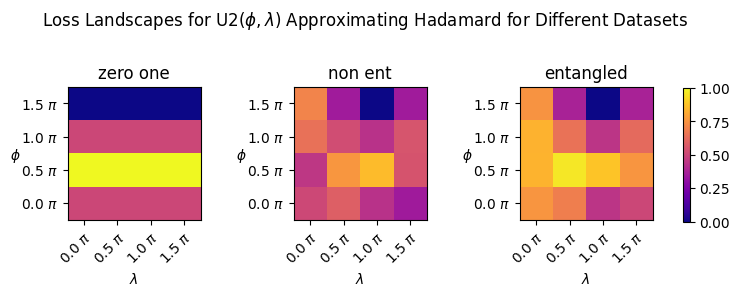

real values


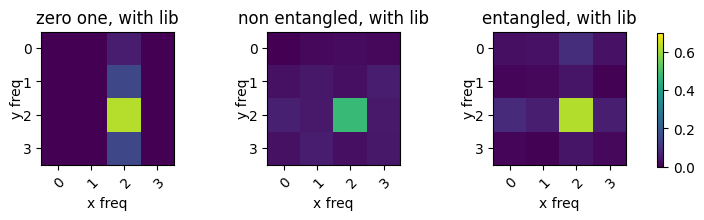

absolute sum:  3.1274404136366187


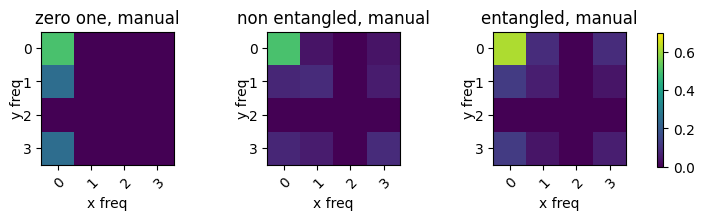

absolute sum:  3.2292239168159025
imaginary values


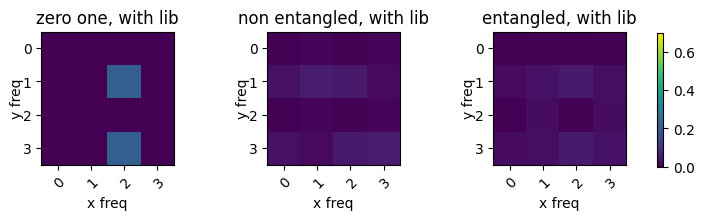

absolute sum:  1.094382840399761


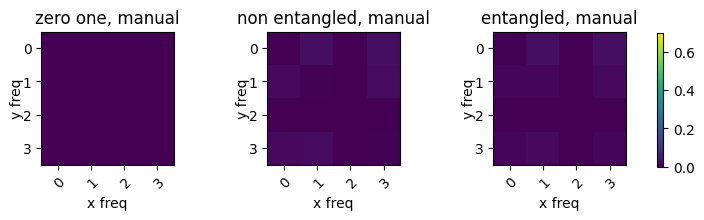

absolute sum:  0.2636326856324346
sum of real and imaginary values


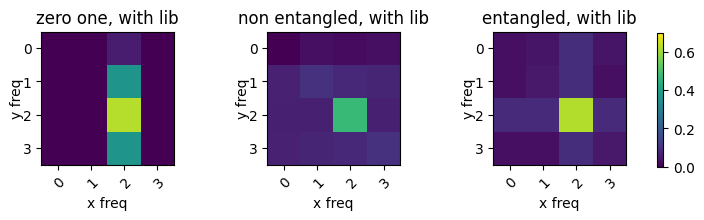

absolute sum:  4.22182325403638


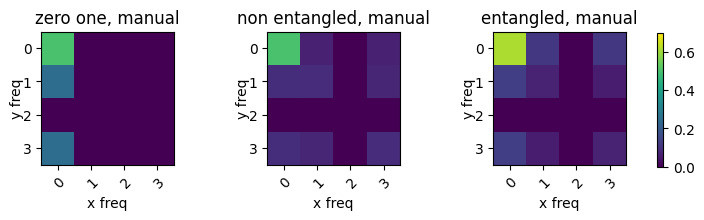

absolute sum:  3.492856602448337


In [ ]:
# fourier testing

# hadamard U2
qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
unitary = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
############
# phase R
# qnn = get_qnn("CudaR", list(range(1)), 1, device="cpu")
# unitary = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
############
num_ticks = 4
# generate data points
non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
entangled_inputs = generate_random_datapoints(5, 2, unitary)
z_o_inputs = get_zero_one_datapoints()
# get 2d landscapes
loss_z_o= generate_2d_loss_landscape(
    num_ticks, z_o_inputs, unitary, qnn
)
loss_non_ent= generate_2d_loss_landscape(
    num_ticks, non_entangled_inputs, unitary, qnn
)
loss_ent= generate_2d_loss_landscape(
    num_ticks, entangled_inputs, unitary, qnn
)
landscapes = [loss_z_o, loss_non_ent, loss_ent]

#test fourier stuff
print("fourier stuff")
fourier_landscape_z_o = get_fourier_landscape(z_o_inputs, unitary, qnn,num_ticks).values
z_o_fd, z_o_f_plot = calc_fourier_density(landscapes[0])
print("FD manual custom:", z_o_fd)
fourier_landscape_non_entangled = get_fourier_landscape(non_entangled_inputs, unitary, qnn,num_ticks).values
n_e_fd, non_ent_f_plot = calc_fourier_density(landscapes[1])
print("FD manual custom:", n_e_fd)
fourier_landscape_entangled = get_fourier_landscape(entangled_inputs, unitary, qnn,num_ticks).values
e_fd, ent_f_plot = calc_fourier_density(landscapes[2])
print("FD manual custom:", e_fd)

# differences possibly explained by different loss landscape sampling
plot_row(landscapes, ["zero one", "non ent","entangled"], "Hadamard", "U2", mode="default")
print("real values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).real), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).real)))

print("imaginary values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).imag), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).imag)))

print("sum of real and imaginary values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)+np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)+np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).imag)+np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).real), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).imag)+np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).real)))
# print(calc_fourier_density(landscapes[0]))
# print(calc_fourier_density(landscapes[1]))
# print(calc_fourier_density(landscapes[2]))


In [ ]:
# EXP on Hadamard
run_hadamard()

In [ ]:
# EXP on Pauli-X
run_pauli_x()

In [ ]:
# EXP on Pauli-Y
run_pauli_y()

In [ ]:
# EXP on Pauli-Z
run_pauli_z()

In [ ]:
# EXP on Phase (S)
run_phase_s()